# DDPM with HuggingFace Diffusers

### What You Will Learn

This project focuses on building and training a custom diffusion model pipeline using the HuggingFace Diffusers library. Throughout the development, you will implement the key concepts behind Denoising Diffusion Probabilistic Models (DDPM) and assemble them into a complete, functional workflow:

- Design a custom diffusion pipeline
  - Implement the core ideas of diffusion models, specifically DDPM
  - Load and prepare a dataset for training
  - Explore the process of adding noise to data using a configurable scheduler
  - Build and train a UNet-based neural network
  - Integrate all components into a working pipeline

Once the fundamentals of training and sampling are established, an additional notebook is provided to scale the project further. This includes running distributed training on multiple GPUs with Accelerate, as well as integrating TensorBoard for experiment tracking and monitoring of critical metrics.

Finally, the project outlines potential next steps for extending the work towards more advanced diffusion methods and architectures.

<p align="center">
  <img src="DDPM_image.png" width="700"/>
</p>

## Configuracíon

In [2]:
#!pip list

In [3]:
!pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow

Let’s import the libraries we’ll be using and define some helper functions that will come in handy later in the notebook:

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision


def show_images(x):
    """
    Given a batch of images x (normalized in the range [-1, 1]), this function 
    creates a grid and returns it as a PIL.Image.

    A PIL Image refers to an image object provided by the Pillow library 
    (PIL = Python Imaging Library), which is the standard Python library 
    for opening, manipulating, and saving images.
    """
    # Denormalize to [0, 1]
    x = x * 0.5 + 0.5

    # Create a grid: tensor of shape [C, H, W] in the [0, 1] range
    grid = torchvision.utils.make_grid(x)

    # Scale to [0, 255] and convert to uint8
    # 1) Convert the tensor into a valid image format:
    # - clamp(0, 1): ensures all values stay within the valid pixel range.
    # - *255: converts values from [0,1] (float outputs from the network) to [0,255] (real image pixels).
    # - to(torch.uint8): converts to 8-bit unsigned integers (uint8).
    grid = (grid.clamp(0, 1) * 255).to(torch.uint8)  # [C, H, W], uint8

    # 2) Rearrange the tensor to be compatible with PIL
    # - detach(): removes the tensor from the gradient computation graph (we’re not training here).
    # - cpu(): moves the data from GPU memory to CPU memory.
    #   👉 PIL and NumPy cannot read tensors from the GPU; they require data in CPU RAM.
    # - permute(1,2,0): PyTorch tensors use [C,H,W], but images use [H,W,C].
    # - contiguous(): ensures memory layout is consistent so NumPy can read it properly.
    grid = grid.detach().cpu().permute(1, 2, 0).contiguous()  # [H, W, C]

    # 3) Convert the tensor into a NumPy array
    # NumPy serves as the bridge between PyTorch and PIL for image creation.
    grid_np = grid.numpy()

    # 4) Create a real image using PIL (PIL.Image object), which can be displayed or saved to disk.
    return Image.fromarray(grid_np)


def make_grid(images, size=64):
    """
    Given a list of PIL images, stack them into a single row for quick visualization.
    """
    # Create a new blank image with width = (number of images * size) and height = size
    output_im = Image.new("RGB", (size * len(images), size))
    
    # Insert each image into its corresponding position in the row
    for i, im in enumerate(images):
        # Resize each image to (size, size) and paste it at the correct offset
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

In [5]:
# Configure the computing device:
#   - Use "cuda" if an Nvidia GPU is available
#   - Otherwise, fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
torch.cuda.is_available()

True

## Pipelines, modelos, schedulers

The main API of HuggingFace Diffusers is organized into three core components (https://huggingface.co/docs/diffusers/en/using-diffusers/write_own_pipeline):
1. **Pipelines**: High-level classes designed to quickly generate samples from popular pre-trained diffusion models, providing an easy-to-use interface for end users.
2. **Modelos**: Popular architectures for training new diffusion models, such as [UNet](https://arxiv.org/abs/1505.04597)... or [Diffusion Transformers DiT](https://arxiv.org/abs/2212.09748)
3. **Schedulers**: Different techniques used both to generate images from noise during *inference* and to create noisy images during *training*.

Pipelines are extremely useful for end users as a “black box” tool. However, before relying on them, we want to understand what happens under the hood of generative diffusion models.

In the remainder of this notebook, we will build our own pipeline, capable of generating small images from an unconditional model trained on a dataset of our choice.

## Downloading the Dataset

For this example, we will use an image dataset available on the Hugging Face Hub — specifically, [this collection of 1,000 butterfly photos](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset).  

Although this is a relatively small dataset, it is sufficient for our first experiment with unconditional image generation.
If you prefer, you can also use your own custom image collection.

In [7]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

# Hide non-relevant Hugging Face Hub warnings:
# - One warns that we are not authenticated (which we don’t need since we’re not uploading anything).
# - Another warns that the dataset repo has no metadata in its README (not important for our use case).
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub.utils._auth")
import logging
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)

# Load the butterfly dataset directly from the Hugging Face Hub
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Alternatively, you can load images from a local folder instead:
# dataset = load_dataset("imagefolder", data_dir="path/to/your/folder")

# We will train using square images of 32x32 pixels.
# You can try larger image sizes, but keep in mind that this will require more GPU memory.
image_size = 32

# batch_size = number of images processed at once in each training step.
# - Larger batch sizes can speed up training (better GPU utilization).
# - However, they also consume more GPU memory.
batch_size = 64

# Define preprocessing and data augmentation transformations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),   # Resize each image to 32x32
        transforms.RandomHorizontalFlip(),             # Random horizontal flip (data augmentation)
        transforms.ToTensor(),                         # Convert the image to a tensor with values in [0, 1]
        transforms.Normalize([0.5], [0.5]),            # Normalize values to the range [-1, 1]
    ]
)

# Explanation of transforms.Normalize([0.5], [0.5]):
# 1. After ToTensor(), pixel values are in the range [0, 1].
# 2. Subtracting 0.5 shifts values to [-0.5, 0.5].
# 3. Dividing by 0.5 rescales the range to [-1, 1].
# This normalization is commonly used in deep learning, as it improves model training stability.

# Apply the preprocessing to each image in the dataset
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

# Create a DataLoader: it serves transformed images in batches.
# Training on batches (groups of images) is faster and more efficient than processing one by one.
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True  # shuffle=True randomizes the order of images each epoch
)

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Podemos obtener un batch de imágenes y visualizar algunas:

X shape: torch.Size([8, 3, 32, 32])


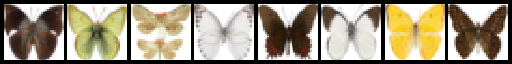

In [8]:
# Get a batch of images from the DataLoader
# Step by step:
#   1. "iter(train_dataloader)" creates an iterator — a "cursor" that starts at the beginning of the DataLoader.
#   2. "next(...)" retrieves the next batch from the cursor.
#      - If the iterator was just created, it will always return the FIRST batch.
#      - After reading, the cursor advances to the next position (like flipping a page).
#   3. Since we always call "iter(...)" again here, the cursor resets each time,
#      so we keep getting the first batch (although its content may vary
#      if the DataLoader was created with shuffle=True).
#   4. ["images"] → select the field containing the transformed images.
#   5. .to(device) → move the tensor to GPU or CPU, depending on availability.
#   6. [:8] → keep only the first 8 images from the batch (the full batch may be larger).
xb = next(iter(train_dataloader))["images"].to(device)[:8]

# Print the shape of the selected image tensor.
# With batch_size = 64 and selecting [:8], we should see: torch.Size([8, 3, 32, 32])
#   - 8 images, 3 channels (RGB), each 32x32 pixels
print("X shape:", xb.shape)

# Visualize the images using our helper function "show_images".
# .resize((8 * 64, 64)) → arranges 8 images in a row, each resized to 64x64 pixels.
# "resample=Image.NEAREST" avoids excessive smoothing when scaling the image grid.
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

We are limiting ourselves to a small dataset with 32-pixel images in order to keep training times manageable within this notebook.

## Define the *Scheduler*

Our training procedure takes input images and adds noise to them, then feeds the noisy images into the model and trains it with a loss function that measures the error between the actual noise and the predicted noise.
During inference, we use the trained model’s predictions to iteratively remove noise.

In `diffusers`, both processes are managed by the **scheduler**.

The noise schedule determines how much noise is added at different time steps (timesteps). Here’s how we can create a *scheduler* using the default configuration for “DDPM”-style training and sampling (based on the paper ["Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239)):

**Tarea 1: Define un scheduler, utilizando `DDPMScheduler` de la librería huggingface diffusers con `1000` train steps y schedule cosenoidal (`'squaredcos_cap_v2'`)**

In [9]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

The **DDPM** paper describes a *corruption* process that adds a small amount of noise at each *timestep*. Given $x_{t-1}$ at a certain step, we obtain the next (slightly noisier) version $x_t$ as:

$$
q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})
$$

In other words: we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$, and add noise scaled by $\beta_t$. The value of $\beta$ is defined for each $t$ according to a *schedule*, which determines how much noise is added at every timestep.

However, we don’t necessarily want to repeat this operation 500 times to obtain $x_{500}$. Instead, there is a formula that allows us to directly compute $x_t$ for any $t$ starting from $x_0$:

$$
q(\mathbf{x}_t \vert \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathbf{I})
$$

where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ y $\alpha_i = 1-\beta_i$.

The *scheduler* takes care of this process for us:

 **Task 2: Using the noise scheduler you defined, plot $\sqrt{\bar{\alpha}_t}$ (`sqrt_alpha_prod`) and  $\sqrt{(1 - \bar{\alpha}_t)}$ ( `sqrt_one_minus_alpha_prod`)  to visualize how the input ($x$) and the noise are scaled and mixed across the different *timesteps***

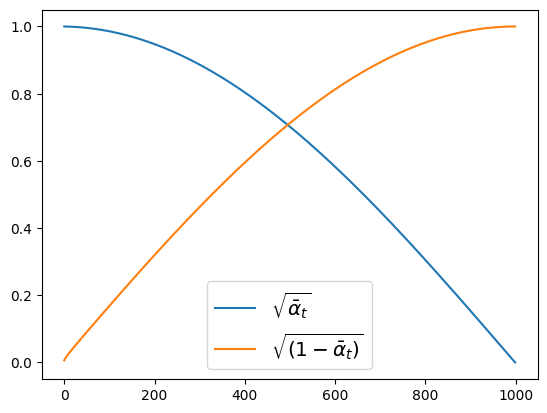

In [10]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Whatever scheduler you chose, you can now use it to add different amounts of noise with the `noise_scheduler.add_noise` function.

**Task 3: Next, take the image batch `xb` defined earlier and add noise at different time steps using the diffusion scheduler. Follow these steps:**

1. Select 8 evenly spaced time values between 0 and 999 and move them to the active device (`torch.linspace`)
2. Generate a random noise tensor with the same shape as the images using `torch.randn_like`
3. Use the scheduler’s `add_noise` method to combine the original images with the noise at the selected time steps.
5. Print the shape of the resulting tensor.
6. Visualize the noisy images in a grid with 8 columns (`show_images(xxxxxxx).resize((8 * 64, 64), resample=Image.NEAREST)`)

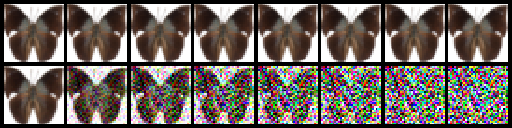

In [11]:
# Select a single image from the batch (e.g., the first one)
idx = 0
x0 = xb[idx:idx+1].to(device)        # (1, C, H, W)

# Repeat that same image 8 times to form a visualization batch
x0_8 = x0.repeat(8, 1, 1, 1)         # (8, C, H, W)

# 8 evenly spaced timesteps between 0 and 999
timesteps = torch.linspace(start=0, end=999, steps=8).long().to(device)

# Generate ONE noise pattern and repeat it so the noise is identical across the 8 columns
noise = torch.randn_like(x0).to(device)  # (1, C, H, W)
noisy_x8 = noise.repeat(8, 1, 1, 1)      # (8, C, H, W)

# Add noise with the scheduler using different timesteps for each replica
noisy_images = noise_scheduler.add_noise(x0_8, noisy_x8, timesteps)

# Display as a grid with 8 columns
# Top row: original image repeated; bottom row: progressively noisier versions
show_images(torch.cat([x0_8, noisy_images], dim=0)).resize((8 * 64, 2 * 64), resample=Image.NEAREST)

## Define the model


Now we arrive at the core component: the noise-prediction model.

Many diffusion models use architectures that are variants [U-net](https://arxiv.org/abs/1505.04597), and that’s what we’ll use here.

In short:
- The model passes the input image through several blocks of ResNet layers, each of which halves the image size.
- Then it goes through the same number of blocks that upsample back to the original size.
- There are *skip connections* that link features from the downsampling path to the corresponding layers in the upsampling path.

A key property of this model is that it predicts images with the same spatial size as the input, which is exactly what we need here.

`Diffusers` provides a `UNet2DModel` class that builds the desired architecture in PyTorch.

**Task 4: Import `UNet2DModel` from `diffusers` ([Partial docs](https://huggingface.co/docs/diffusers/main/en/api/models/unet2d#diffusers.UNet2DModel), [Github](https://github.com/huggingface/diffusers/tree/main/src/diffusers/models/unets)) and create a model with the following configuration:**

- `sample_size = image_size`  ⟶ target image resolution (e.g., 32).
- `in_channels = 3` ⟶ input channels (RGB).
- `out_channels = 3` ⟶ output channels (RGB).
- `layers_per_block = 2` ⟶ number of ResNet layers per UNet block.
- `block_out_channels = (64, 128, 128, 256)` ⟶ block widths (more channels ⇒ more parameters).
- `down_block_types = ("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D")` Some notes:
  * The down blocks (`DownBlock2D` y `AttnDownBlock2D`) are composed of multiple layers.
  * `DownBlock2D` contains multiple `ResnetBlock2D`, each formed by a `GroupNorm`, a `SiLU` activation, a 2D convolution and a residual conection. At the end of the block a `Downsample2D` halves the image resolution.
  * `AttnDownBlock2D` includes the same structure, but also adds an `AttentionBlock` after each `ResnetBlock2D`, incorporating spatial self-attention with normalization and residual connections. This enables the model to capture global dependencies in the image.
  * By default: In the diffusers source code, each down block (`DownBlock2D`, `AttnDownBlock2D`) receives an `add_downsample` parameter, which defaults to `True` and applies a `Downsample2D` layer to halve the resolution. However, the model avoids this reduction in the last down block (`add_downsample=False`), reaching the bottleneck.
  * The number of channels per block is determined by `block_out_channels`. The change in channel count is achieved because the convolution defines not only the kernel size but also how many filters it applies. Each filter produces one output feature map, and the total number of maps corresponds to `out_channels`. Thus, if the input has 64 channels and `out_channels=128`, the convolution creates 128 filters of size `(64, 3, 3)` spanning all input channels, producing 128 distinct output maps.
  * `up_block_types = ("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"` form the up path, symmetric to the down path. Each block doubles the resolution and merges its inputs with skip connections from the corresponding down block, then adjusts channels with convolutions. The Attn blocks also apply spatial self-attention.

      | Fase          | Blocks | Type              | Attention | Input resolution | Input channels | Output resolution | Output channels |
      |--------------:|-------:|-------------------|:--------:|-------------------:|----------------:|------------------:|---------------:|
      | Downsampling  | 1      | `DownBlock2D`     |    ✖     | 32 × 32            | 3               | 16 × 16           | 64             |
      | Downsampling  | 2      | `DownBlock2D`     |    ✖     | 16 × 16            | 64              | 8 × 8             | 128            |
      | Downsampling  | 3      | `AttnDownBlock2D` |    ✔     | 8 × 8              | 128             | 4 × 4             | 128            |
      | Downsampling  | 4      | `AttnDownBlock2D` |    ✔     | 4 × 4              | 128             | 4 × 4             | 256            |
      | Bottleneck    |   –    | —                 |    –     | 4 × 4              | 256             | 4 × 4             | 256            |
      | Upsampling    | 1      | `AttnUpBlock2D`   |    ✔     | 4 × 4              | 256 (+ *skips*) | 8 × 8             | 128            |
      | Upsampling    | 2      | `AttnUpBlock2D`   |    ✔     | 8 × 8              | 128 (+ *skips*) | 16 × 16           | 128            |
      | Upsampling    | 3      | `UpBlock2D`       |    ✖     | 16 × 16            | 128 (+ *skips*) | 32 × 32           | 64             |
      | Upsampling    | 4      | `UpBlock2D`       |    ✖     | 32 × 32            | 64  (+ *skips*) | 32 × 32           | 64             |


<p align="center">
  <img src="Unet_arq.png" width="800"/>
</p>

In [12]:
from diffusers import UNet2DModel

# Create a 2D U-Net model with a custom configuration
model = UNet2DModel(
    sample_size=32,           # input resolution: 32x32
    in_channels=3,            # input channels (RGB)
    out_channels=3,           # output channels (reconstructed RGB)
    layers_per_block=2,       # number of ResNet layers per block
    block_out_channels=(64, 128, 128, 256),  # output channels of each downsampling block
    down_block_types=(        # downsampling block types
        "DownBlock2D",       # Block 1: 32x32 -> 16x16, channels 3 -> 64
        "DownBlock2D",       # Block 2: 16x16 -> 8x8, channels 64 -> 128
        "DownBlock2D",       # Block 3: 8x8 -> 4x4, channels 128 -> 128 + self-attention
        "AttnDownBlock2D",   # Block 4: 4x4 -> 4x4, channels 128 -> 256 + self-attention
    ),
    up_block_types=(          # upsampling block types
        "AttnUpBlock2D",     # Block 1: 4x4 -> 8x8, channels 256 -> 128 + self-attention (uses skip connections)
        "AttnUpBlock2D",     # Block 2: 8x8 -> 16x16, channels 128 -> 128 + self-attention (uses skips)
        "UpBlock2D",         # Block 3: 16x16 -> 32x32, channels 128 -> 64 (uses skips)
        "UpBlock2D",         # Block 4: 32x32 -> 32x32, channels 64 -> 64 (uses skips)
    ),
)

# Move the model to the available device (CPU or GPU)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

When working with higher-resolution inputs, you may want to use more downsampling and upsampling blocks, and keep attention layers only at the lowest-resolution stages (the bottleneck) to reduce memory usage.

We can verify that when we pass a batch of data along with some random timesteps, the model produces an output with the same shape as the input data.

In [13]:
with torch.no_grad():
    model_prediction = model(noisy_x8, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

## Trainning

**Task 5: Implement the diffusion model training loop following these steps**

* Start by instantiating a noise schedule with `DDPMScheduler` setting `num_train_timesteps` to `1000` and `beta_schedule` to `squaredcos_cap_v2`.
* Define an AdamW optimizer `(torch.optim.AdamW)` over model.parameters() with a constant learning rate of 4e-4.
* Iterate over the `train_dataloader` for multiple `epochs`, (e.g., 30). In each iteration, extract batch["images"], move it to device, and name it clean_images. *Remember that in each epoch, the DataLoader fetches examples from the Dataset in groups of size batch_size: (If batch_size=32 and you have 10,000 images, the DataLoader will create groups of 32 images each, i.e., 10000/32 = 313 batches, and each of those 313 batches is processed in a training step.)*
*  Generate a noise tensor with the same dimensions as `clean_images`
*  Sample one timestep per image.
*  Use `noise_scheduler.add_noise(...)` to obtain `noisy_images` with the noise level corresponding to each timestep.
* Pass `noisy_images` and `timesteps` to the model to obtain the predicted noise.
* Compute the MSE loss (`F.mse_loss`) between the prediction and the true noise.
* Perform backpropagation.
* Append the numeric loss value to a list named losses.
* Update the parameters with `optimizer.step()` 
* Call `optimizer.zero_grad()` to clear gradients before the next step.
* Add a small informational log with the average loss from the last epoch.


In [14]:
# Define the DDPM noise scheduler.
# - num_train_timesteps=1000 → number of diffusion timesteps (noise steps).
# - beta_schedule="squaredcos_cap_v2" → how the noise magnitude is distributed across timesteps.
num_train_timesteps = 1000
noise_scheduler = DDPMScheduler(num_train_timesteps=num_train_timesteps, beta_schedule="squaredcos_cap_v2")

# Define the AdamW optimizer for the model parameters.
# - lr=4e-4 → learning rate.
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

# List to store loss values for plotting later.
losses = []
n_epochs = 30

# Training loop (30 full epochs over the dataset).
for epoch in range(n_epochs):
    # Iterate over the dataloader in batches.
    for step, batch in enumerate(train_dataloader):
        
        # Get the batch of clean images and move them to the device (GPU or CPU).
        clean_images = batch["images"].to(device)

        # Generate a Gaussian noise tensor with the same shape as the clean images.
        noise = torch.randn_like(clean_images).to(device)
        
        # Store the batch size.
        bs = clean_images.shape[0]

        # Sample a random timestep for each image in the batch.
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=device).long()

        # Add noise to the clean images according to each sampled timestep.
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Pass the noisy images and timesteps to the model to predict the noise.
        # return_dict=False makes the model return a tuple; we take the first element.
        model_prediction = model(noisy_images, timesteps).sample

        # Compute the loss as mean squared error between predicted noise and true noise.
        loss = F.mse_loss(model_prediction, noise)

        # Backpropagation: compute gradients.
        loss.backward()

        # Save the numerical loss value for later plotting.
        losses.append(loss.item())

        # Update model parameters using the optimizer.
        optimizer.step()

        # Reset accumulated gradients before the next step.
        optimizer.zero_grad()
        
    # Print the average loss of the last epoch every 5 epochs.
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.11708611343055964
Epoch:10, loss: 0.0901148640550673
Epoch:15, loss: 0.07188938139006495
Epoch:20, loss: 0.06414961977861822
Epoch:25, loss: 0.06298102205619216
Epoch:30, loss: 0.059401726350188255


When plotting the loss, we observe that the model improves quickly at the beginning and then continues improving at a slower pace (this becomes more evident if we use a logarithmic scale, as shown on the right).

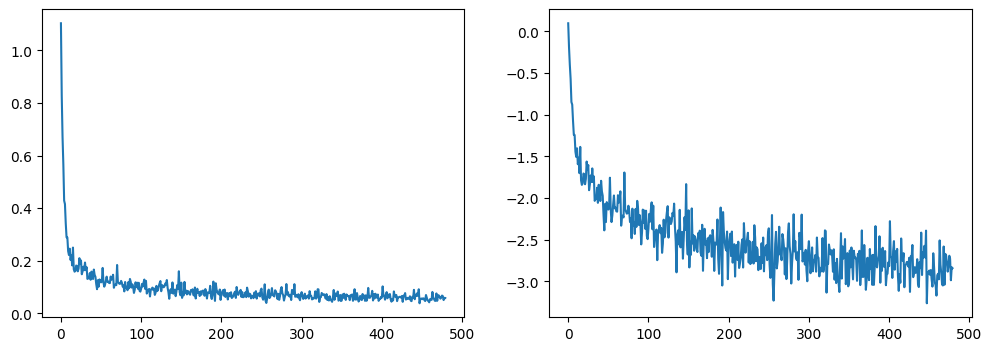

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Generating new samples with the trained model

### Option 1: Create a Pipeline

**Task 6: Let’s set up a `DDPMPipeline` following these steps.**

We’ll reuse the previously defined components:
- `model`: your trained `UNet2DModel`, already moved to the appropriate `device`.
- `noise_scheduler`: the `DDPMScheduler` (or equivalent) with the same configuration used during training.


1. Import `DDPMPipeline` from `diffusers`.
2. Instantiate the pipeline by explicitly passing the `unet` (your `model`) and the `scheduler` (`noise_scheduler`).
3. Invoke the pipeline to sample:
   - Use `num_inference_steps=1000`.
   - Generate a batch with `batch_size=8`.
4. Store the result of the call in a variable (e.g., `pipeline_output`).
5. Visualize the resulting images (use the `make_grid` function).

In [16]:
from diffusers import DDPMPipeline
import time

start = time.time()

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
image_pipe = image_pipe.to(device)
pipeline_output = image_pipe(num_inference_steps=50, batch_size=8)
images = pipeline_output.images  # List of PIL images

end = time.time()
print(f"Tiempo de muestreo: {end - start:.2f} segundos")

100%|██████████| 50/50 [00:02<00:00, 24.72it/s]

Tiempo de muestreo: 2.04 segundos


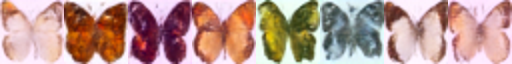

In [17]:
# Visualize all generated images in a single row
grid_pil = make_grid(pipeline_output.images, size=64)
display(grid_pil)


We can save a pipeline to a local folder as follows:

In [18]:
image_pipe.save_pretrained("my_pipeline")

The subfolders `scheduler` and `unet` contain everything needed to reconstruct those components. For example, inside the `unet` folder you will find the model weights (`diffusion_pytorch_model.bin`) ) along with a configuration file that specifies the UNet architecture. To reload it, you simply use.

`image_pipe_reloaded = DDPMPipeline.from_pretrained("my_pipeline")`

### Opción 2: Write a sampling loop

If you inspect the method inside the pipeline, you can see what happens when we call `image_pipe()`:

In [19]:
#import inspect
#print(inspect.getsource(image_pipe.__call__))

We start from random noise and iterate through the scheduler’s timesteps from the noisiest to the least noisy, removing a small amount of noise at each step based on the model’s prediction.

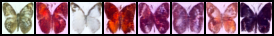

In [20]:
# Random starting point: generate 8 initial images as pure noise
sample = torch.randn(8, 3, 32, 32).to(device)

# Iterate over all timesteps defined by the scheduler
for i, t in enumerate(noise_scheduler.timesteps):

    # Model prediction at this step
    #   - The model receives the current noisy sample and the timestep t
    #   - It predicts the "residual" (the noise present in the image)
    with torch.no_grad():
        pred = model(sample, t).sample

    # The scheduler combines:
    #   - the predicted noise (pred)
    #   - the current sample (sample)
    #   - the timestep t
    # to compute the image state at the previous step.
    # The result is returned as an object with several fields.
    # The most important one is `.prev_sample`, which represents the
    # less noisy version of the image (the sample "stepped back" one timestep).
    sample = noise_scheduler.step(pred, t, sample).prev_sample

# After the loop finishes, 'sample' should approximate clean images
show_images(sample)

The `noise_scheduler.step()` function performs the necessary computations to properly update `sample`. There are several sampling methods; later, we will see how to swap in a different sampler to speed up image generation with already trained models, and we’ll discuss more about the theory behind sampling in diffusion models.

### DDIM

**Task 7: Now implement image sampling using the **DDIM** algorithm instead of DDPM and compare the runtime.**

Configure a `DDIMPipeline` using the same trained UNet (`model`) and a `DDIMScheduler` initialized from the scheduler configuration used during training, then generate and visualize a set of images.

Hint:  `DDIMScheduler.from_config(image_pipe.scheduler.config)`

100%|██████████| 30/30 [00:01<00:00, 26.39it/s]

Sampling time: 1.14 seconds


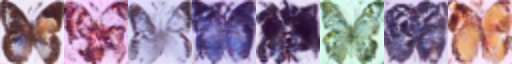

In [21]:
from diffusers import DDIMScheduler, DDIMPipeline
import time

# Create a DDIM scheduler from the same configuration used by the original DDPM scheduler
ddim = DDIMScheduler.from_config(image_pipe.scheduler.config)

# Define a DDIM pipeline using the trained UNet and the new scheduler
image_pipe_ddim = DDIMPipeline(unet=model, scheduler=ddim)
image_pipe_ddim = image_pipe_ddim.to(device)

# Start a timer to measure sampling time
start = time.time()

# Run the pipeline to generate images
# - num_inference_steps=30: fewer steps than standard DDPM → faster inference
# - eta=0.0: deterministic sampling (same input → same output)
# - batch_size=8: generate 8 images in parallel
pipeline_ddim_output = image_pipe_ddim(num_inference_steps=30, eta=0.0, batch_size=8)

# Compute and print the elapsed time
end = time.time()
print(f"Sampling time: {end - start:.2f} seconds")

# Visualize all generated images in a single row using the helper function make_grid
grid_pil = make_grid(pipeline_ddim_output.images, size=64)
display(grid_pil)